# CZ4042 Neural Networks & Deep Learning
## Assignment - 1: Part B, Question 3

> Gupta Jay  
> U1822549K  
> School of Computer Science and Engineering  
> Nanyang Technological University, Singapore  

## Imports

In [88]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [89]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup
from tensorflow.keras.layers import Embedding, Reshape, Concatenate
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from tensorflow.keras import backend as K
import sys
import operator

In [90]:
print(tf.__version__)

2.6.0


In [91]:
# Supress any warnings for clean presentation
import warnings
warnings.filterwarnings("ignore")

In [92]:
df = pd.read_csv('hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [93]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [94]:
# Split data
train_dataframe = df[df['year'] <= 2020]
val_dataframe = df[df['year'] > 2020]

# Generate tf.data.Dataset objects for each dataframe
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

# Batch the datasets
train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

In [95]:
# Categorical features (integers)
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical features encoded (integers)
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature (String)
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Categorical feature encoded (String)
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")

# Numerical Features Encoded
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

# Combining all inputs
all_inputs = [
    month,
    flat_model_type,
    storey_range,
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years,
    floor_area_sqm
]

In [96]:
embedding_layers = []

# All Categorial Variables
categorial_variables = ["month", "flat_model_type", "storey_range"]

# All Categorial Variables (encoded)
categorial_variables_encoded = [month_encoded, flat_model_type_encoded, storey_range_encoded]

# Generate an embedding for each categorial variable and store it
for categorial_variable, categorial_variable_encoded in zip(categorial_variables, categorial_variables_encoded):
    # Output dimensions specified in the assignment manual
    unique_categories  = train_dataframe[categorial_variable].nunique()
    embedding_size = np.floor((unique_categories)/2)
    embedding_size = int(embedding_size)

    # Input Dimensions
    vocab  = unique_categories + 1
    
    # Embedding Layer
    embedding = Embedding(input_dim = vocab, output_dim = embedding_size)(categorial_variable_encoded)

    # Reshaping such that it can be concatenated
    embedding = Reshape((-1,))(embedding)
    embedding_layers.append(embedding)

In [97]:
# Combining all Encoded inputs
all_features = layers.concatenate(
    [
        embedding_layers[0],
        embedding_layers[1],
        embedding_layers[2],
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded,
    ]
)

### R2 Value Metric

In [98]:
def coeff_determination(y_true, y_pred):
    # Custom Metric to calculate R2 Value
    # Source: https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    SS_res =  K.sum(K.square(y_true-y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

## Part A: Introducing Early Stopping

In [99]:
def early_stopping_callback(metric, mode, patience, verbose):
    # Early Stopping if the model does not improve
    return EarlyStopping(monitor=metric, mode=mode, verbose=verbose, patience=patience)

### 2-layer Feedforward Neural Network

In [100]:
def getModel(features, first_layer_activation, second_layer_activation):
    # Inputs -> Encoded Features (Concatenated) -> Dense -> Dense (Output)
    x = layers.Dense(10, activation=first_layer_activation)(features)
    output = layers.Dense(1, activation=second_layer_activation)(x)
    model = keras.Model(all_inputs, output)
    return model

def getOptimizer(lr):
    # Adam Optimizer (Default Parameters) -> Stochastic Gradient Descent
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    return optimizer

### Model Training

* **Loss Function**: Mean Squared Error
* **Learning Rate**: 0.05
* **Epochs**: 100
* **Batch Size**: 128 

In [101]:
loss = "mse"
metrics = [RootMeanSquaredError(), coeff_determination]
optimizer = getOptimizer(0.05)

model = getModel(all_features, "relu", "linear")
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

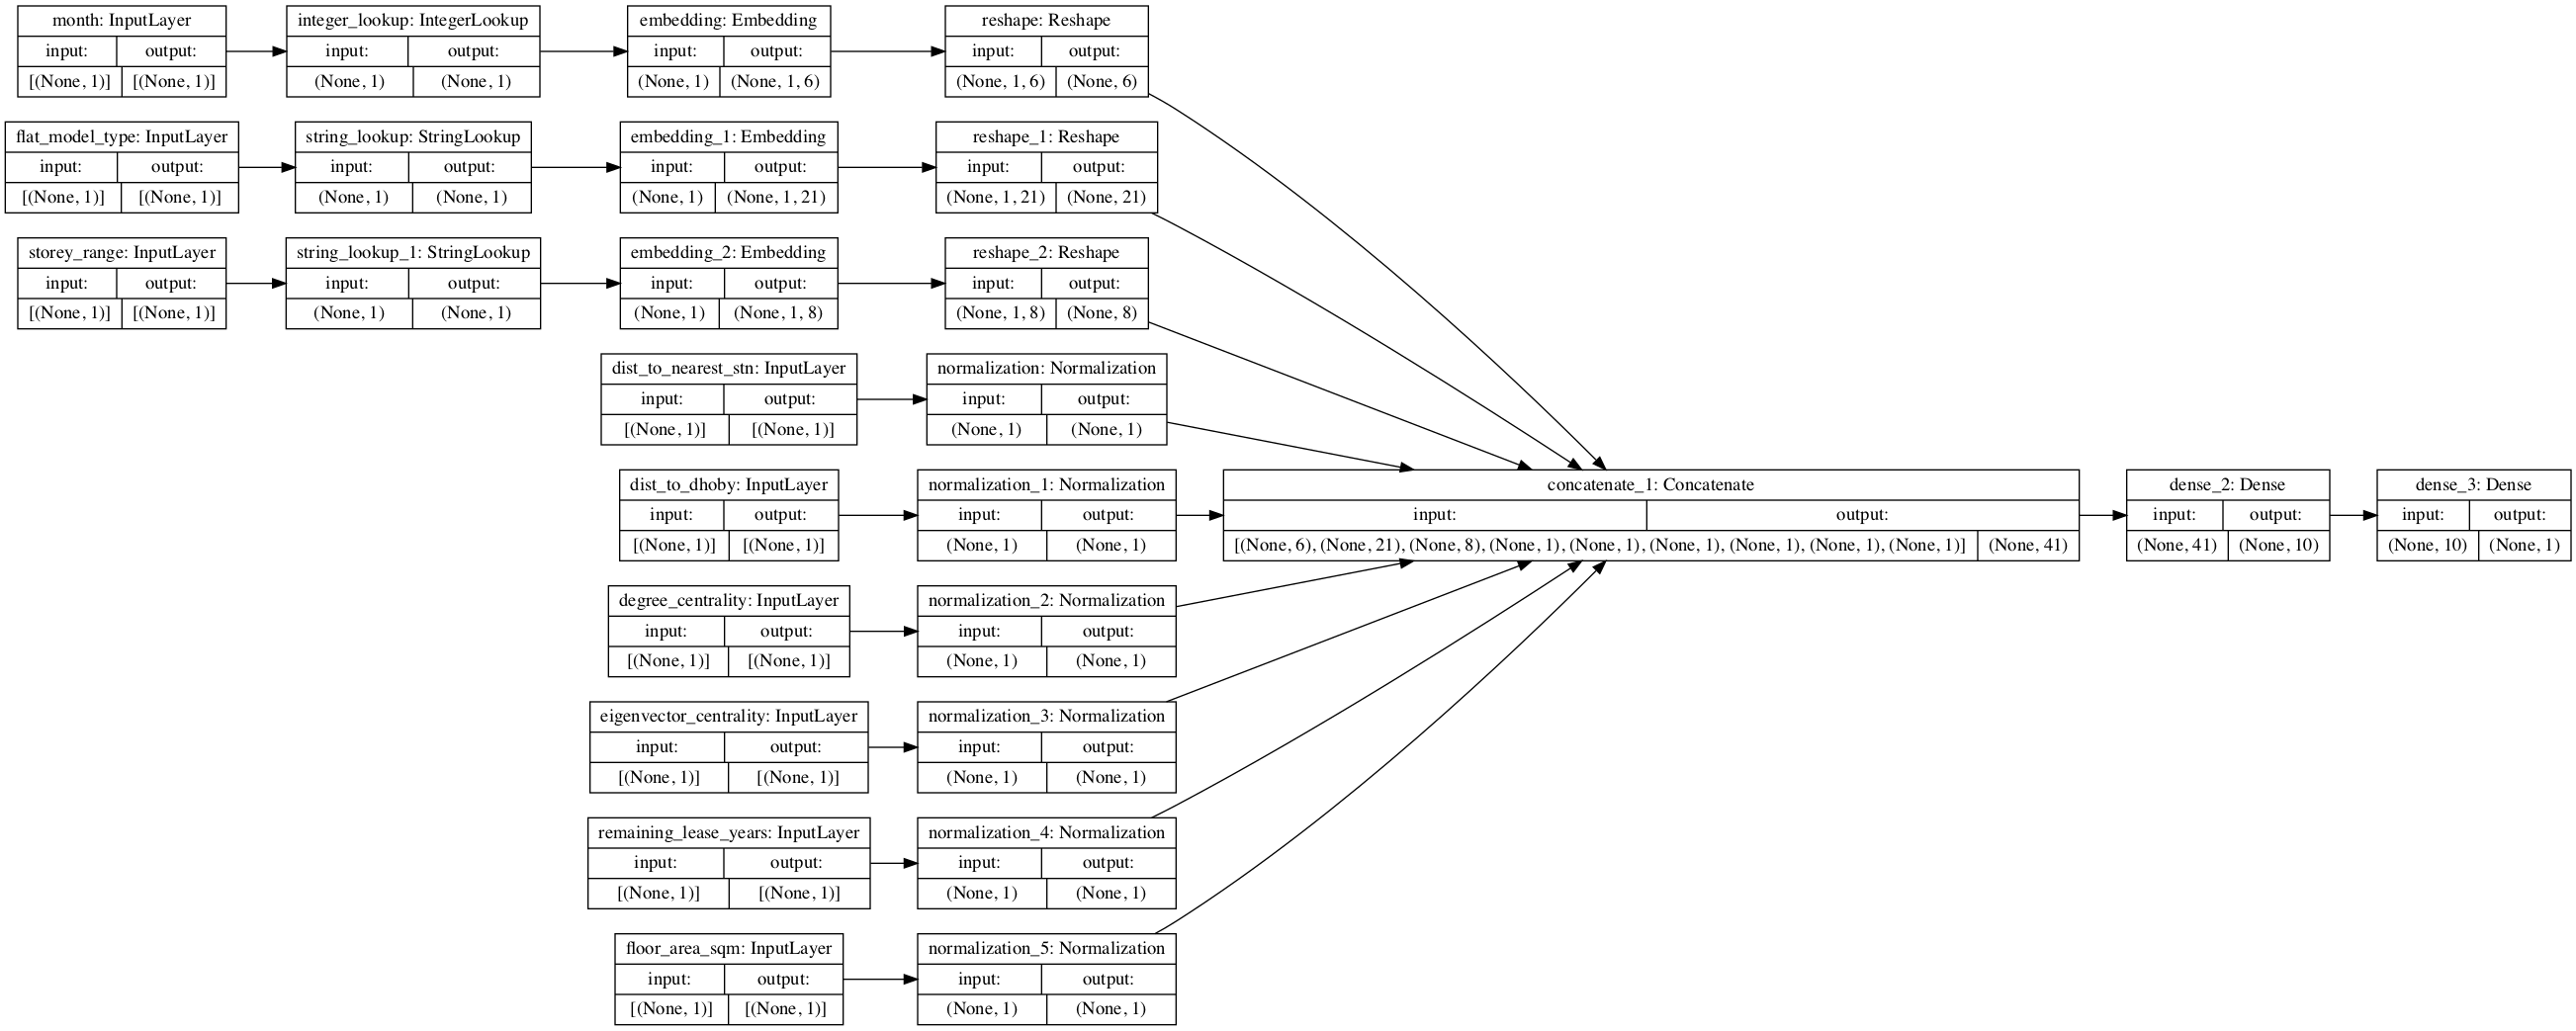

In [102]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [103]:
epochs = 100
verbose = 1
callbacks = [early_stopping_callback('val_loss', 'min', 10, verbose)]
batch_size = 128

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=verbose, callbacks = callbacks, batch_size=batch_size)

Epoch 1/100
683/683 [==============================] - 4s 3ms/step - loss: 48933765120.0000 - root_mean_squared_error: 221209.7812 - coeff_determination: -1.0547 - val_loss: 12630631424.0000 - val_root_mean_squared_error: 112386.0781 - val_coeff_determination: 0.5132
Epoch 2/100
683/683 [==============================] - 3s 3ms/step - loss: 8245698560.0000 - root_mean_squared_error: 90805.8281 - coeff_determination: 0.6486 - val_loss: 10499447808.0000 - val_root_mean_squared_error: 102466.8125 - val_coeff_determination: 0.5936
Epoch 3/100
683/683 [==============================] - 3s 3ms/step - loss: 7232543744.0000 - root_mean_squared_error: 85044.3672 - coeff_determination: 0.6911 - val_loss: 9285679104.0000 - val_root_mean_squared_error: 96362.2266 - val_coeff_determination: 0.6393
Epoch 4/100
683/683 [==============================] - 3s 3ms/step - loss: 6520332288.0000 - root_mean_squared_error: 80748.5781 - coeff_determination: 0.7214 - val_loss: 8084582400.0000 - val_root_mean_s

## Part B: Recursive Feature Elimination

### Helper Functions

In [104]:
def get_model_features(binary_vector_mask):
    # Removing the features not required by using the Binary Vector Mask
    features = all_features.copy()

    # Getting Indices where value is 0 i.e. feature is not required
    indices = [i for i, x in enumerate(binary_vector_mask) if x == 0]

    # Reverse the list to preserve index locations
    for index in sorted(indices, reverse=True):
        del features[index]
        
    return features

experiment_df = pd.DataFrame(columns=['Feature List', 'RMSE', 'Val Loss', 'Epoch Num.', 'R2'])
best_features_df = pd.DataFrame(columns=['Features'])

# Recreating all features for reference
all_features = []
all_features.extend(embedding_layers)
all_features.extend(
    [dist_to_nearest_stn_encoded,
    dist_to_dhoby_encoded,
    degree_centrality_encoded,
    eigenvector_centrality_encoded,
    remaining_lease_years_encoded,
    floor_area_sqm_encoded])

feature_name_converter = {
    "reshape/Reshape:0": "month",
    "reshape_1/Reshape:0": "flat_model_type",
    "reshape_2/Reshape:0": "storey_range",
    "normalization/truediv:0": "distance_to_nearest_stn",
    "normalization_1/truediv:0": "dist_to_dhoby",
    "normalization_2/truediv:0": "degree_centrality",
    "normalization_3/truediv:0": "eigenvector_centrality",
    "normalization_4/truediv:0": "remaining_lease_years",
    "normalization_5/truediv:0": "floor_area_sqm"
}

def record_experiment(features, rmse, val_loss, r2, epoch_num):
    all_missing_features = []

    full_features =[]
    for x in all_features:
        full_features.append(x.name)

    reduced_features =[]
    for x in features:
        reduced_features.append(x.name)

    missing_features = [item for item in full_features if item not in reduced_features]
    for missing_feature in missing_features:
        all_missing_features.append(feature_name_converter[missing_feature])
    
    feature_list = 'Feature(s) Removed: ' + ' , '.join(all_missing_features)
    new_entry = {
        'Feature List': feature_list,
        'RMSE': rmse,
        'Val Loss': val_loss,
        'Epoch Num.': epoch_num,
        'R2': r2
        }
    return new_entry

### 2-layer Feedforward Neural Network

In [105]:
def get_model_with_custom_features(features, first_layer_activation, second_layer_activation):
    # Inputs -> Encoded Features -> Concatenated -> Dense -> Dense (Output)
    x = Concatenate()(features)
    x = layers.Dense(10, activation=first_layer_activation)(x)
    output = layers.Dense(1, activation=second_layer_activation)(x)
    model = keras.Model(all_inputs, output)
    return model

### RFE Algorithm

In [106]:
# Each index represents a feature. 1 means feature is present. O means feature is not present.
# Initally all features are present. 
binary_vector_mask = [1, 1, 1, 1, 1, 1, 1, 1, 1]

# Reference Val Loss is the minimum of the previous model with all 9 features. 
lastLoss = min(history.history['val_loss'])

histories = {}
iterationCount = 0
layer_with_min_loss = None

# Model Metrics
loss = "mse"
metrics = [RootMeanSquaredError(), coeff_determination]
optimizer = getOptimizer(0.05)
epochs = 100
verbose = 0
callbacks = [early_stopping_callback('val_loss', 'min', 10, verbose)]

# Algorithm
while(sum(binary_vector_mask) > 0):
    # While there are still features available to remove
    iterationCount += 1

    if(layer_with_min_loss is not None):
        # Set a very high value to the loss of removal of the last layer such that we do not remove it again
        histories[layer_with_min_loss] = sys.maxsize

    print("Iteration: %0.0f" % iterationCount)

    for index, vector in enumerate(binary_vector_mask):
        # Iterate through all features
        if(vector == 1):
            # Only train model if feature is present
            
            # Get filtered features, i.e. only those features who are represented by 1 in the binary mask
            binary_vector_mask[index] = 0
            print("Binary Mask: ", binary_vector_mask)
            features = get_model_features(binary_vector_mask)
            binary_vector_mask[index] = 1

            # Compile & Train Model
            model_ = get_model_with_custom_features(features, "relu", "linear")
            model_.compile(loss=loss, optimizer=optimizer, metrics=metrics)
            history_ = model_.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks, verbose=verbose)

            # Store trained model metrics
            epoch_num = np.argmin(history_.history['val_loss'])
            min_loss = history_.history['val_loss'][epoch_num]
            min_rmse = history_.history['val_root_mean_squared_error'][epoch_num]
            r2 = history_.history['val_coeff_determination'][epoch_num]

            # Store in a Pandas Dataframe for future Reference
            experiment_df = experiment_df.append(record_experiment(features, min_rmse, min_loss, r2, epoch_num), ignore_index = True)
            histories[index] = min_loss

            print("Validation Loss: %0.2f" % min_loss)
            print()
            
            K.clear_session()

    # Get Reference Loss
    base_model_val_loss = lastLoss

    # Get Layer Index whose removal leads to minimum val loss value
    layer_with_min_loss = min(histories.items(), key=operator.itemgetter(1))[0]
 
    if(base_model_val_loss > min(histories.values())):
        # Remove feature if new loss is lower
        binary_vector_mask[layer_with_min_loss] = 0
        lastLoss = histories[layer_with_min_loss]
    else:
        # We have obtained the best model
        # Break out of the loop
        print("Best Model Achieved.")
        break

Iteration: 1
Binary Mask:  [0, 1, 1, 1, 1, 1, 1, 1, 1]
Validation Loss: 5292457472.00

Binary Mask:  [1, 0, 1, 1, 1, 1, 1, 1, 1]
Validation Loss: 5548882432.00

Binary Mask:  [1, 1, 0, 1, 1, 1, 1, 1, 1]
Validation Loss: 6061371392.00

Binary Mask:  [1, 1, 1, 0, 1, 1, 1, 1, 1]
Validation Loss: 5918700544.00

Binary Mask:  [1, 1, 1, 1, 0, 1, 1, 1, 1]
Validation Loss: 8208735744.00

Binary Mask:  [1, 1, 1, 1, 1, 0, 1, 1, 1]
Validation Loss: 4786109952.00

Binary Mask:  [1, 1, 1, 1, 1, 1, 0, 1, 1]
Validation Loss: 5528730112.00

Binary Mask:  [1, 1, 1, 1, 1, 1, 1, 0, 1]
Validation Loss: 5854488576.00

Binary Mask:  [1, 1, 1, 1, 1, 1, 1, 1, 0]
Validation Loss: 5517011456.00

Iteration: 2
Binary Mask:  [0, 1, 1, 1, 1, 0, 1, 1, 1]
Validation Loss: 4240435456.00

Binary Mask:  [1, 0, 1, 1, 1, 0, 1, 1, 1]
Validation Loss: 5790810624.00

Binary Mask:  [1, 1, 0, 1, 1, 0, 1, 1, 1]
Validation Loss: 6347803136.00

Binary Mask:  [1, 1, 1, 0, 1, 0, 1, 1, 1]
Validation Loss: 5914918912.00

Binary Mask:

### Experiment Results

In [107]:
pd.options.display.max_colwidth = 100
experiment_df[['Feature List', 'RMSE']]

,Feature List,RMSE
0,Feature(s) Removed: month,72749.281250
1,Feature(s) Removed: flat_model_type,74490.820312
2,Feature(s) Removed: storey_range,77854.812500
3,Feature(s) Removed: distance_to_nearest_stn,76933.093750
4,Feature(s) Removed: dist_to_dhoby,90602.070312
5,Feature(s) Removed: degree_centrality,69181.718750
6,Feature(s) Removed: eigenvector_centrality,74355.429688
7,Feature(s) Removed: remaining_lease_years,76514.632812
8,Feature(s) Removed: floor_area_sqm,74276.585938
9,"Feature(s) Removed: month , degree_centrality",65118.625000


## Part C: Model Performance Comparison

In [108]:
val_rmse = history.history['val_root_mean_squared_error']
val_r2 = history.history['val_coeff_determination']
index_min = np.argmin(val_rmse) 

# Printing
print("--------- Model with all 9 input features ------------")
print("Epoch: " + str(index_min+1) + "nd Epoch")
print("Root Mean Squared Error: %0.3f" % val_rmse[index_min])
print("R2 (Coefficient of Determination): %0.3f" % val_r2[index_min])
print("------------------------------------------------------")

print()

min_val_rmse = experiment_df['RMSE'].min()
feature_removed_row = experiment_df.loc[experiment_df['RMSE'] == min_val_rmse]

print("--------- Model with", binary_vector_mask.count(1), "input features ----------------")
print("Epoch: " + str(feature_removed_row["Epoch Num."].item()) + "th Epoch")
print("Root Mean Squared Error: %0.3f" % min_val_rmse)
print("R2 (Coefficient of Determination): %0.3f" % feature_removed_row["R2"].item())
print(feature_removed_row["Feature List"].item())
print("------------------------------------------------------")


--------- Model with all 9 input features ------------
Epoch: 32nd Epoch
Root Mean Squared Error: 73813.875
R2 (Coefficient of Determination): 0.789
------------------------------------------------------

--------- Model with 7 input features ----------------
Epoch: 20th Epoch
Root Mean Squared Error: 64971.500
R2 (Coefficient of Determination): 0.836
Feature(s) Removed: degree_centrality , eigenvector_centrality
------------------------------------------------------


## Part D: Examine the change in Model Performance

By using Recursive Feature Elimination (RFE), we are able to identiy features whose elimination leads to a better model performance (lower validation loss). Removal of features `degree_centrality` and `eigenvector_centrality` leads to lower `Root Mean Sequared Error` and higher `R2 (Coefficient of Determination)`.     

### Ranking of features based on experiments

In [109]:
experiments_eval = experiment_df.iloc[:9]
experiments_eval = experiments_eval.sort_values("RMSE")
experiments_eval = experiments_eval.drop(experiments_eval.columns[[2, 3, 4]], 1)
experiments_eval.reset_index(drop=True, inplace=True)
experiments_eval['Feature List'] = experiments_eval['Feature List'].map(lambda x: x.lstrip('Feature(s) Removed'))
experiments_eval.index = np.arange(1, len(experiments_eval) + 1)
experiments_eval

,Feature List,RMSE
1,: degree_centrality,69181.718750
2,: month,72749.281250
3,: floor_area_sqm,74276.585938
4,: eigenvector_centrality,74355.429688
5,: flat_model_type,74490.820312
6,: remaining_lease_years,76514.632812
7,: distance_to_nearest_stn,76933.093750
8,: storey_range,77854.812500
9,: dist_to_dhoby,90602.070312


If we assume that all features are independant of each other, then, the table above indicates the importance of each feature in our model. However, we observe that there is some correlation between the features since after the removal of feature `degree_centrality`, the next feature to be removed is `eigenvector_centrality` rather than `month`. Removal of pair <`month`, `degree_centrality`> leads to a higher validation loss than <`eigenvector_centrality`, `degree_centrality`>.

## End of Part B, Q3.

## Conclusion

For questions in Part B, we examined building a neural network model that predicts the HDB prices with a set of features related to the house, and tried to optimize the parameters of the model. Firstly, we built a model that took one-hot encoded vectors for all the variables. Afterwards, we added embedding layers for the categorical variables for a more richer representation. The embedding layers increased the performance of the model. Finally, we investigated the importance of each feature in the model and removed those which lead to a better performance.

### Limitations 
In our current approach, we only have two layers and the hidden layer has only `10` neurons. It will be better if we have more number of neurons and a deeper network such that our model can learn richer representations of the data.  

I also think that the number of data points (training examples) are low, and our model will perform better if we have more data.

### Most Impactful Optimization
Adding the embedding layers to learn from more richer representative of input data certainly helped the model to increase its performance. However, the recursive feature elimination had the most impact in optimizing the model. After removing `eigenvector_centrality` and `degree_centrality`, the R2 value (Coefficient of Determination) of the model increased significantly.

### Better Options
There are many machine learning algorithms to perform regression tasks, similar to our question. Some examples include Decision Tree Regression, Support Vector Machines (SVM), and Random Forests. I think whether they will outperform our current neural network model depends on their hyperparameter tuning and other settings. 

### Factors increasing to Price Increase
With the Recursive Feature Elimination (RFE) algorithm, we were able to remove `eigenvector_centrality` and `degree_centrality` as input features. We can look at the `RMSE` values sorted in the reverse order (highest to loweest) to determine what are the factors that lead to the most increase in prices. From the table plotted above, some factors like `dist_to_dhoby` which represents the distance from Dhoby Ghaut MRT station and `storey_range` are important in predicting prices. This is reasonable as location is an important factor in real-estate and taking Dhoby Ghaut MRT, which is located centrally, serves as a good anchor for this purpose.   